In [11]:
# Imports
import numpy as np
import pickle

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as path_effects
import matplotlib.patheffects as fx
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

In [12]:
# Confidence ellipses
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpatches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Load results

In [13]:
# Load results
# Save results
results = pickle.load(open('../results/combined_results.pkl', 'rb'))

# Robustness figures

In [14]:
# Parameters for all

# Colors
c_casc = 'C0'
c_nank = 'C1'
c_nank2 = 'C1'
c_jpt = 'C2'
c_ak = 'C3'
c_nz = 'C4'
c_pk = 'C5'
c_tw = 'C6'

## For all distances

In [15]:
# Parameters
cc_thr = 0.07  # cross-correlation threshold defining if two bins are well correlated
dx_bin = 10  # in km, bin size along strike
v_min = 3.5  # in km/d, minimum speed we consider tremor migrates (used in correlation calculations)

min_mag = 2.2  # minimum magnitude of counted earthquakes

max_dists = [10, 20, 30, 50, 100]  # in km, distance from tremor within which earthquakes are counted

regions = ['casc', 'nank2', 'jpt', 'pk', 'tw', 'nz', 'ak']
region_names = ['Cascadia', 'Nankai', 'Japan Trench', 'Parkfield', 'Taiwan', 'Hikurangi', 'Alaska']
colors = [c_casc, c_nank2, c_jpt, c_pk, c_tw, c_nz, c_ak]

In [16]:
# Extract
results_tmp = {}

for max_dist in max_dists:
    results_tmp[f'{max_dist:d}km'] = {}
    for region in regions:
        results_tmp[f'{max_dist:d}km'][region] = dict_tmp = {}
        dict_tmp['cc_log'] = results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['cc_log']
        dict_tmp['cc_d'] = results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['cc_d']
        dict_tmp['n_eq'] = results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['n_eq']


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_39572/1917659474.py:28: RuntimeWarning: invalid value encountered in scalar divide
  pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])


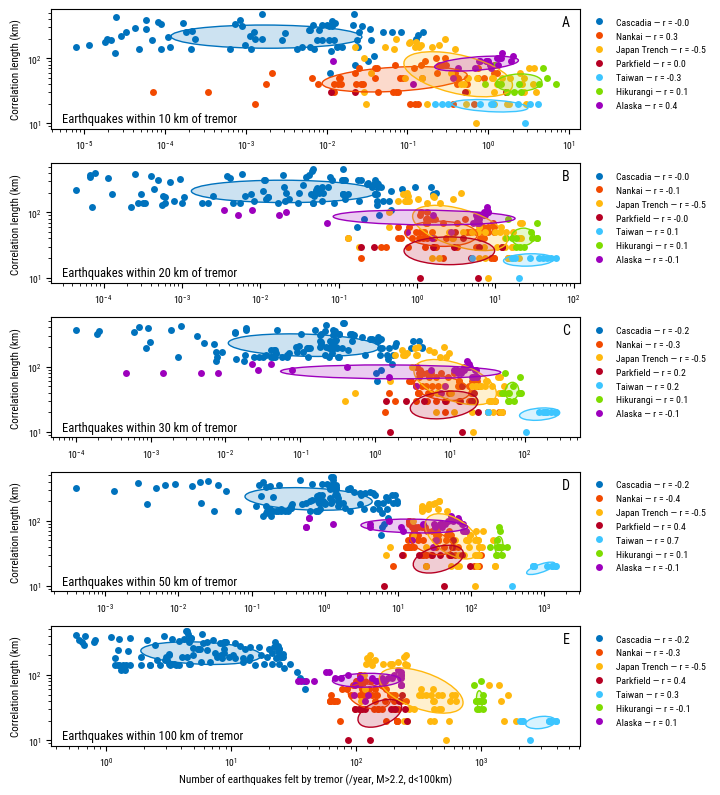

In [17]:
# Plot
with plt.style.context('grl'):
    fig, axes = plt.subplots(len(max_dists), 1, figsize=(7.24, 8))

    for ii, (max_dist, ax) in enumerate(zip(max_dists, axes)):
        if ii==4: ax.set_xlabel(f'Number of earthquakes felt by tremor (/year, M>{min_mag:.1f}, d<{max_dist:d}km)')
        ax.set_ylabel('Correlation length (km)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.text(0.98, 0.95, 'ABCDE'[ii], fontsize=10, va='top', ha='right', transform=ax.transAxes)
        ax.text(0.02, 0.03, f'Earthquakes within {max_dist:d} km of tremor', fontsize=9, va='bottom', ha='left', transform=ax.transAxes)

        for region, region_name, color in zip(regions, region_names, colors):
            cc_log = results_tmp[f'{max_dist:d}km'][region]['cc_log']
            n_eq = results_tmp[f'{max_dist:d}km'][region]['n_eq']
            cc_d = results_tmp[f'{max_dist:d}km'][region]['cc_d']
            
            if np.isnan(cc_log):  # means that the correlation failed, because all y values are the same
                cc_log = 0

            ax.plot(n_eq, cc_d, 'o', mec='none', mfc=color, ms=5, label=f'{region_name} — r = {cc_log:.1f}')    
    
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()

    # Add ellipses
    for ii, (max_dist, ax) in enumerate(zip(max_dists, axes)):
            # duplicate axis
            ax_twin = fig.add_axes(ax.get_position())
            ax_twin.set_xlim(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]))
            ax_twin.set_ylim(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]))
            ax_twin.axis('off')

            for region, region_name, color in zip(regions, region_names, colors):
                cc_log = results_tmp[f'{max_dist:d}km'][region]['cc_log']
                n_eq = results_tmp[f'{max_dist:d}km'][region]['n_eq']
                cc_d = results_tmp[f'{max_dist:d}km'][region]['cc_d']
                # Ellipse parameters
                n_std = 1
                lw = 1
                alpha=.2
                valid_value = np.isfinite(cc_d) & (n_eq>0) & (cc_d>0) & np.isfinite(n_eq)
                confidence_ellipse(np.log10(n_eq[valid_value]), np.log10(cc_d[valid_value]), ax=ax_twin, n_std=n_std, linewidth=lw, edgecolor=color, facecolor=to_rgba(color, alpha))

    plt.savefig('../figures/distance_robustness.pdf')
    plt.savefig('../figures/distance_robustness.png', dpi=300)
    plt.show()

## For all parameters

In [20]:
# Extract
# --> Parameters
min_mags = [2, 2.2, 2.4]
max_dists = [30, 50]

cc_thrs = [0.05, 0.07, 0.1]
v_mins = [1., 3.5, 10.]  # [1., 3.5, 10.]
dx_bins = [5, 10]

regions = ['casc', 'nank2', 'jpt', 'ak', 'nz', 'pk', 'tw']

# --> Extraction
# initialize
cc_all = {}
for region in regions:
    cc_all[region] = []
cc_all['global'] = []

# Extract
for dx_bin in dx_bins:
    for min_mag in min_mags:
        for max_dist in max_dists:
            for v_min in v_mins:
                for cc_thr in cc_thrs:
                    cc_all['global'].append(results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}']['global_cc'])
                    for region in regions:
                        cc_all[region].append(results[f'dx{dx_bin:d}km'][f'm{min_mag:.1f}'][f'{max_dist:d}km'][f'v{v_min:.1f}kmd'][f'cc{cc_thr:.2f}'][region]['cc_log'])
                        if np.isnan(cc_all[region][-1]):
                            cc_all[region][-1] = 0

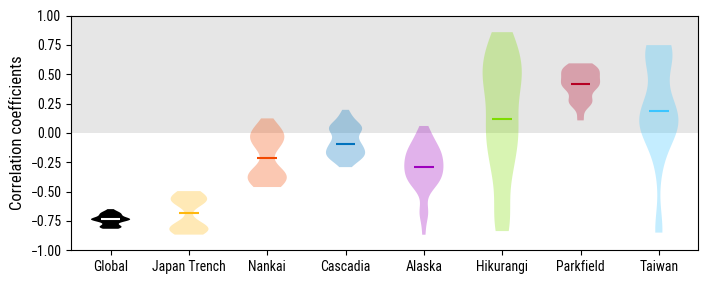

In [21]:
# Aggregate results
fig, ax = plt.subplots(figsize=(7.24, 3))

ax.set_ylabel('Correlation coefficients')
ax.set_xlim(-.5, 7.5)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(['Global', 'Japan Trench',  'Nankai', 'Cascadia', 'Alaska', 'Hikurangi', 'Parkfield', 'Taiwan'])

ax.set_ylim(-1, 1)
ax.axhspan(0, 1, fc='.9')

colors = ['k', c_jpt, c_nank2, c_casc, c_ak, c_nz, c_pk, c_tw]

for x, (region, color) in enumerate(zip(['global', 'jpt', 'nank2', 'casc', 'ak', 'nz', 'pk', 'tw'], colors)):
        v = ax.violinplot(cc_all[region], positions=[x], showextrema=False, showmedians=True)
        v['bodies'][0].set_facecolor(color)
        v['cmedians'].set_color(color)
        if x == 0:
                v['bodies'][0].set_alpha(1)
                v['bodies'][0].set_facecolor(color)
                v['cmedians'].set_color('w')

plt.tight_layout()
plt.savefig('../figures/all_parameters_robustness.pdf')
plt.savefig('../figures/all_parameters_robustness.png', dpi=300)
plt.show()